In [2]:
import pandas as pd
ames_housing = pd.read_csv("datasets/house_prices.csv", na_values="?")
target_name = "SalePrice"
data = ames_housing.drop(columns=target_name)
target = ames_housing[target_name]

In [3]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

data_numerical = data[numerical_features]

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

model1 = make_pipeline(StandardScaler(), SimpleImputer(strategy = "mean"), LinearRegression())
model2 = make_pipeline(SimpleImputer(strategy = "mean"), DecisionTreeRegressor())

cv1 = cross_val_score(model1, data_numerical, target, cv = 10, scoring='r2')
cv2 = cross_val_score(model2, data_numerical, target, cv = 10, scoring='r2')

In [23]:
print("linear : ", cv1.mean(), cv1.std())
print("dec. tree : ", cv2.mean(), cv2.std())

linear :  0.720027306286322 0.13735454339342962
dec. tree :  0.6219352165151012 0.09852659122181164


# Solution

In [27]:
# Linear Regression

from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(
    StandardScaler(), SimpleImputer(), LinearRegression()
)
cv_results_linear_regression = cross_validate(
    linear_regression, data_numerical, target, cv=10, return_estimator=True,
    n_jobs=2
)
cv_results_linear_regression["test_score"].mean()

0.7189885186244973

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree = make_pipeline(
    SimpleImputer(), DecisionTreeRegressor(random_state=0)
)
cv_results_tree = cross_validate(
    tree, data_numerical, target, cv=10, n_jobs=2
)
cv_results_tree["test_score"].mean()

0.6224784392065366

# Moi

In [50]:
from sklearn.model_selection import GridSearchCV
print(model2.get_params())
param_grid = {"decisiontreeregressor__max_depth" : np.arange(1, 15, 1)}
tree_clf = GridSearchCV(model2, param_grid = param_grid, cv = 10)
tree_clf.fit(data_numerical, target)
print(">> Clés des résultats : ", tree_clf.cv_results_.keys())
print(">> Profondeur : ", tree_clf.best_params_['decisiontreeregressor__max_depth'])

{'memory': None, 'steps': [('simpleimputer', SimpleImputer()), ('decisiontreeregressor', DecisionTreeRegressor())], 'verbose': False, 'simpleimputer': SimpleImputer(), 'decisiontreeregressor': DecisionTreeRegressor(), 'simpleimputer__add_indicator': False, 'simpleimputer__copy': True, 'simpleimputer__fill_value': None, 'simpleimputer__missing_values': nan, 'simpleimputer__strategy': 'mean', 'simpleimputer__verbose': 0, 'decisiontreeregressor__ccp_alpha': 0.0, 'decisiontreeregressor__criterion': 'mse', 'decisiontreeregressor__max_depth': None, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_leaf_nodes': None, 'decisiontreeregressor__min_impurity_decrease': 0.0, 'decisiontreeregressor__min_impurity_split': None, 'decisiontreeregressor__min_samples_leaf': 1, 'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__min_weight_fraction_leaf': 0.0, 'decisiontreeregressor__random_state': None, 'decisiontreeregressor__splitter': 'best'}
>> Clés des résult

In [51]:
tree_clf.best_params_

{'decisiontreeregressor__max_depth': 6}

# Solution

In [60]:
import numpy as np
from sklearn.model_selection import GridSearchCV

params = {"decisiontreeregressor__max_depth": np.arange(1, 15)}
search = GridSearchCV(tree, params, cv=10)
cv_results_tree_optimal_depth = cross_validate(
    search, data_numerical, target, cv=10, return_estimator=True, n_jobs=2,
)
cv_results_tree_optimal_depth["test_score"].mean()

0.6672402956343579

In [59]:
cv_results_tree_optimal_depth["test_score"]

array([0.62364186, 0.75007937, 0.7092939 , 0.61593787, 0.76008656,
       0.72481088, 0.69675545, 0.73549956, 0.63187688, 0.72866512])

C:\Users\mathieu.rajerison\Miniconda3\envs\scikit-learn-course\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='max depth'>

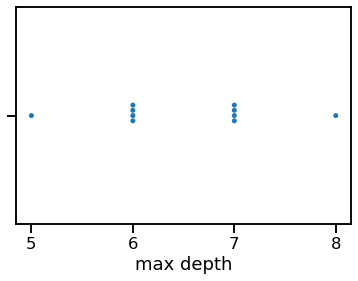

In [58]:
import seaborn as sns
sns.set_context("talk")

# Meilleurs paramètres par folds
max_depth = [
    estimator.best_params_["decisiontreeregressor__max_depth"]
    for estimator in cv_results_tree_optimal_depth["estimator"]
]
max_depth = pd.Series(max_depth, name="max depth")
sns.swarmplot(max_depth)

# Moi

In [72]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = make_pipeline(StandardScaler(), SimpleImputer(strategy="mean"))

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-impute', numerical_preprocessor, numerical_columns)])

model = make_pipeline(preprocessor, DecisionTreeRegressor())

test_scores = cross_val_score(model, data, target, cv = 10)
print(test_scores.mean())

0.7422387767852034


# Solution

Pour les var. catégorielles, utilisation de :
```
SimpleImputer(strategy="constant", fill_value="missing"),
OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
```

Utilisation de `make_column_transformer`

In [73]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder

# Utilisation de SimpleImputer et de 
categorical_processor = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
)
numerical_processor = SimpleImputer()

preprocessor = make_column_transformer(
    (categorical_processor, selector(dtype_include=object)),
    (numerical_processor, selector(dtype_exclude=object))
)
tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=0))

In [ ]:
cv_results = cross_validate(
    tree, data, target, cv=10, return_estimator=True, n_jobs=2
)
cv_results["test_score"].mean()